<a href="https://colab.research.google.com/github/varnitvishwakarma/personal_use/blob/main/sketch%20to%20face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input # type: ignore
from keras.preprocessing.image import img_to_array # type: ignore
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
import re


In [9]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image
SIZE = 256

image_path = './dataset/sketches'
img_array = []

sketch_path = './dataset/photos'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))


for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)

    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resizing images
    image = cv2.resize(image, (SIZE, SIZE))

    # normalizing image
    image = image.astype('float32') / 255.0

    #appending normal normal image
    img_array.append(img_to_array(image))
    # Image Augmentation

    # horizontal flip
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
     # rotate anti clockwise
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))


for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)

    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resizing images
    image = cv2.resize(image, (SIZE, SIZE))

    # normalizing image
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))

    #Image Augmentation
    # horizontal flip
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
     # rotate anti clockwise
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))









100%|██████████| 188/188 [00:01<00:00, 156.99it/s]


In [10]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

Total number of sketch images: 1504
Total number of images: 1504


In [11]:
# defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Sketches', color = 'green', fontsize = 20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Image', color = 'black', fontsize = 20)
    plt.imshow(sketches)

    plt.show()

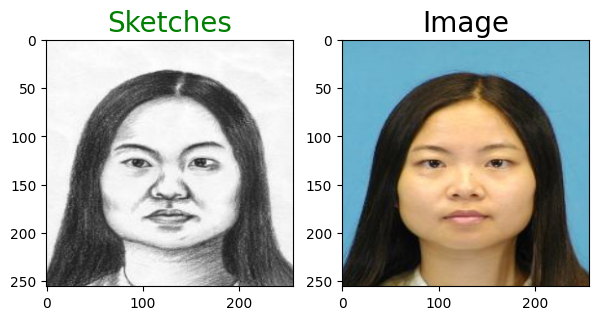

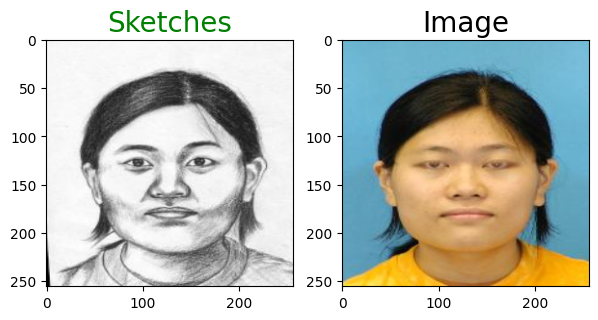

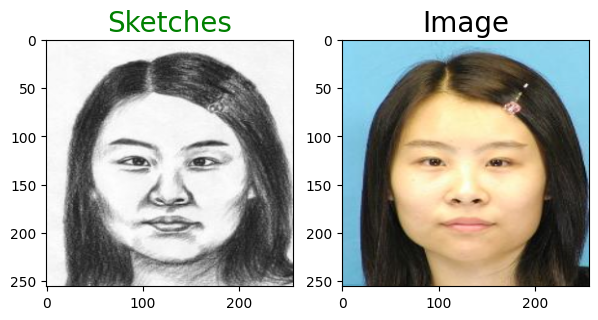

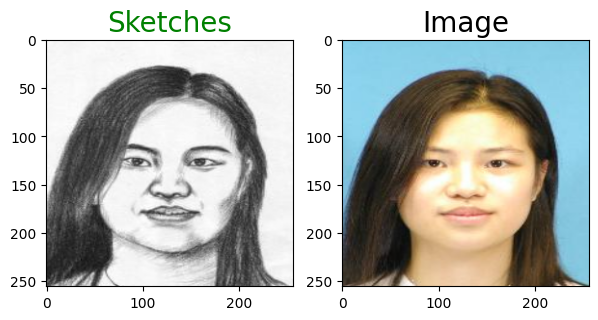

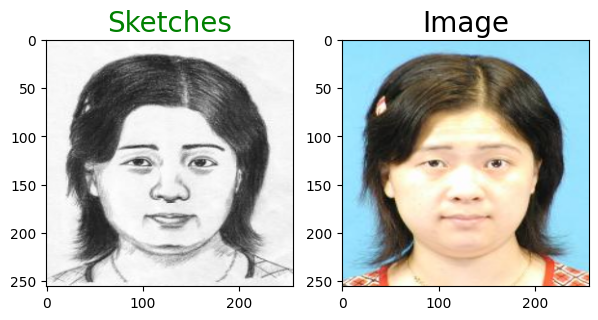

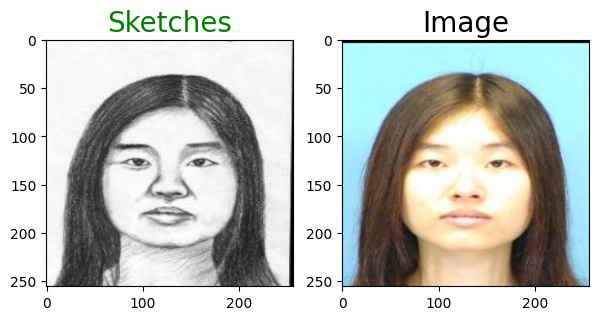

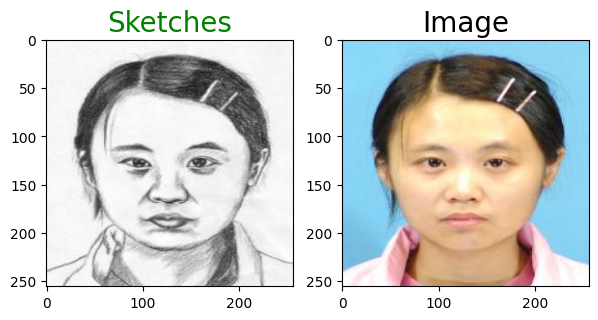

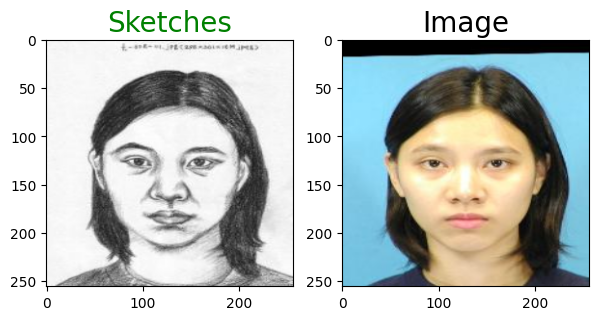

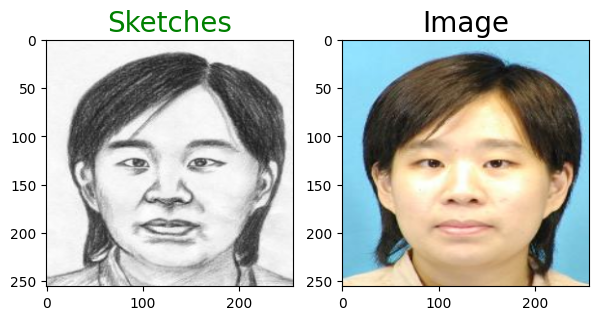

In [12]:
ls = [i for i in range(0,65,8)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])

In [13]:
train_sketch_image = sketch_array[:1400]
train_image = img_array[:1400]
test_sketch_image = sketch_array[1400:]
test_image = img_array[1400:]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Train color image shape: (1400, 256, 256, 3)
Test color image shape (104, 256, 256, 3)


In [14]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

In [15]:
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU())
    return upsample

In [16]:
def model():
    encoder_input = keras.Input(shape = (SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32,4)(x)
    x = downsample(64,4,False)(x)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)

    encoder_output = downsample(512,4)(x)

    decoder_input = upsample(512,4,True)(encoder_output)
    x = upsample(256,4,False)(decoder_input)
    x = upsample(128,4, True)(x)
    x = upsample(64,4)(x)
    x = upsample(32,4)(x)
    x = upsample(16,4)(x)
    x = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)


    return tf.keras.Model(encoder_input, decoder_output)


In [17]:
# to get summary of model
model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 127, 127, 16)      768       
                                                                 
 sequential_1 (Sequential)   (None, 62, 62, 32)        8320      
                                                                 
 sequential_2 (Sequential)   (None, 30, 30, 64)        32768     
                                                                 
 sequential_3 (Sequential)   (None, 14, 14, 128)       131584    
                                                                 
 sequential_4 (Sequential)   (None, 6, 6, 256)         525312    
                                                                 
 sequential_5 (Sequential)   (None, 2, 2, 512)         209920

In [22]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_image, train_sketch_image, epochs =50)

Epoch 1/50
44/44 [==============================] - 10s 147ms/step - loss: 0.1275 - acc: 0.8162
Epoch 2/50
44/44 [==============================] - 6s 144ms/step - loss: 0.1075 - acc: 0.8471
Epoch 3/50
44/44 [==============================] - 6s 147ms/step - loss: 0.1007 - acc: 0.8541
Epoch 4/50
44/44 [==============================] - 6s 145ms/step - loss: 0.0965 - acc: 0.8592
Epoch 5/50
44/44 [==============================] - 7s 149ms/step - loss: 0.0960 - acc: 0.8619
Epoch 6/50
44/44 [==============================] - 6s 146ms/step - loss: 0.0907 - acc: 0.8661
Epoch 7/50
44/44 [==============================] - 7s 148ms/step - loss: 0.0861 - acc: 0.8714
Epoch 8/50
44/44 [==============================] - 6s 146ms/step - loss: 0.0854 - acc: 0.8735
Epoch 9/50
44/44 [==============================] - 7s 150ms/step - loss: 0.0814 - acc: 0.8771
Epoch 10/50
44/44 [==============================] - 7s 148ms/step - loss: 0.0830 - acc: 0.8790
Epoch 11/50
44/44 [=============================

In [23]:
prediction_on_test_data = model.evaluate(test_image, test_sketch_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

4/4 [==============================] - 1s 67ms/step - loss: 0.0768 - acc: 0.9150
Loss:  0.07681495696306229
Accuracy:  91.5


In [24]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("sketch",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("Image",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

1/1 [==============================] - 0s 19ms/step


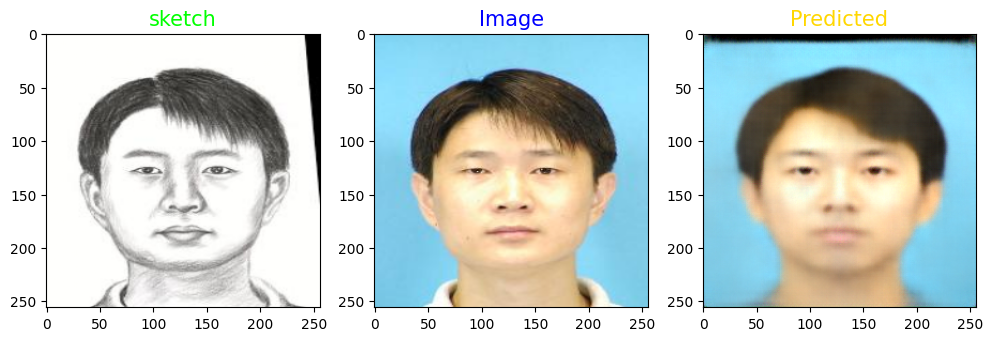

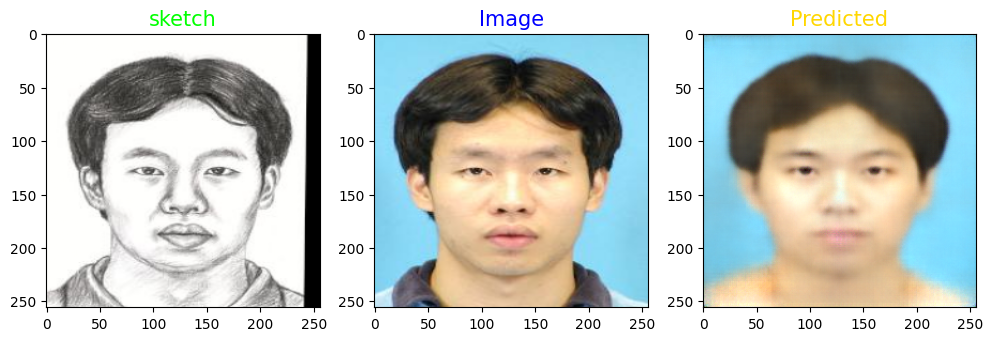

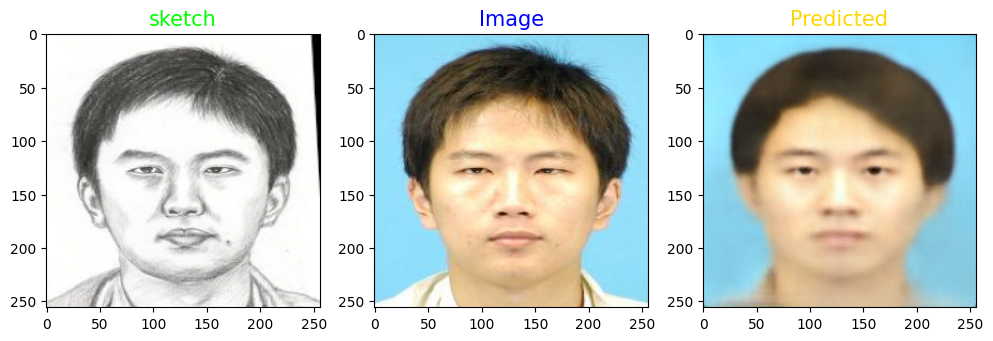

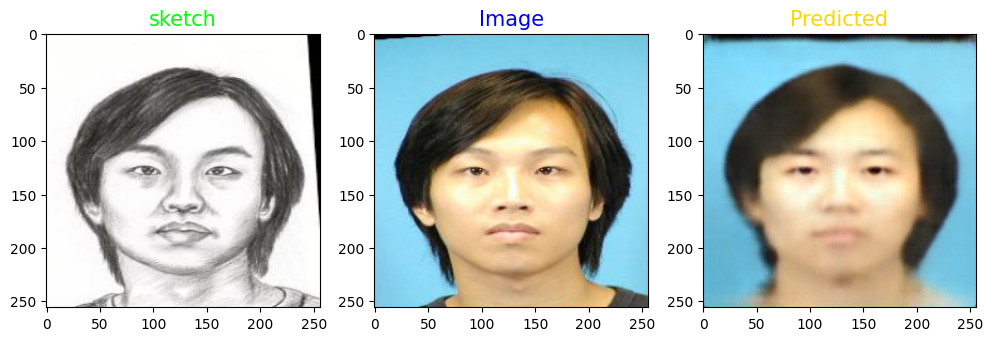

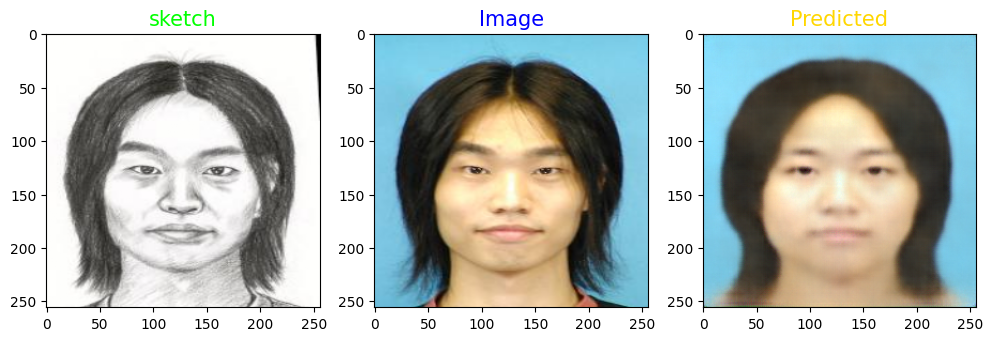

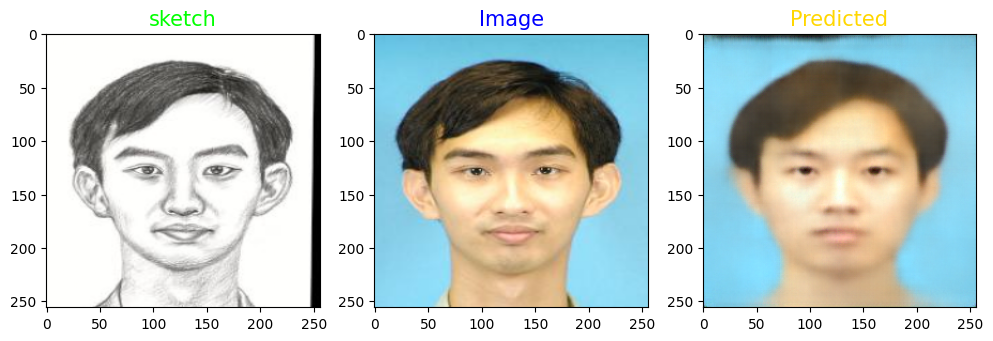

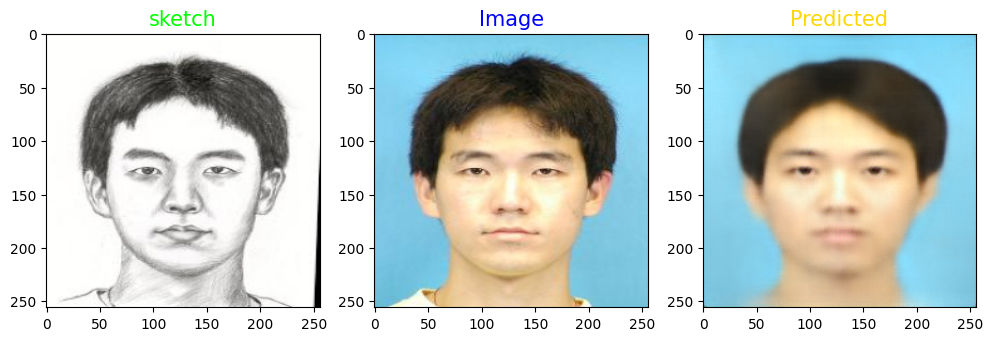

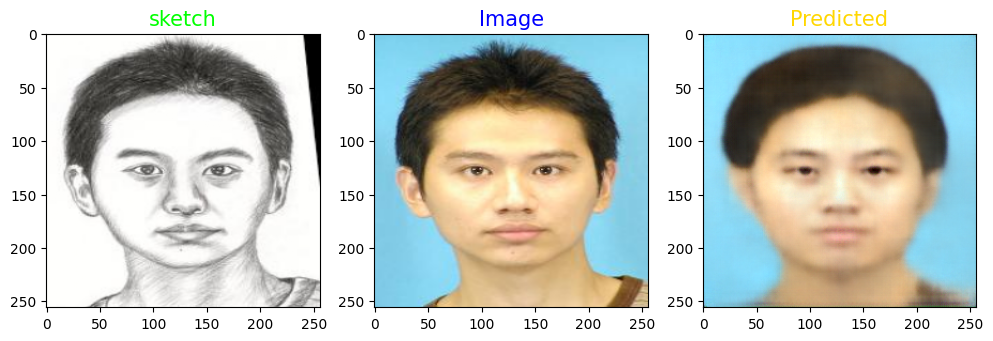

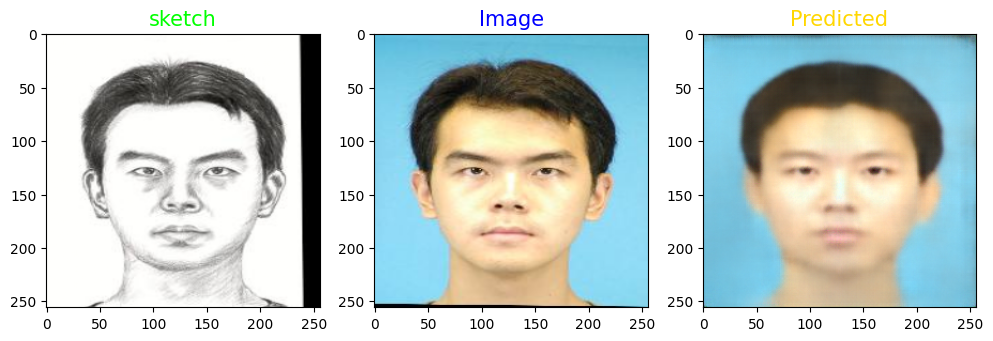

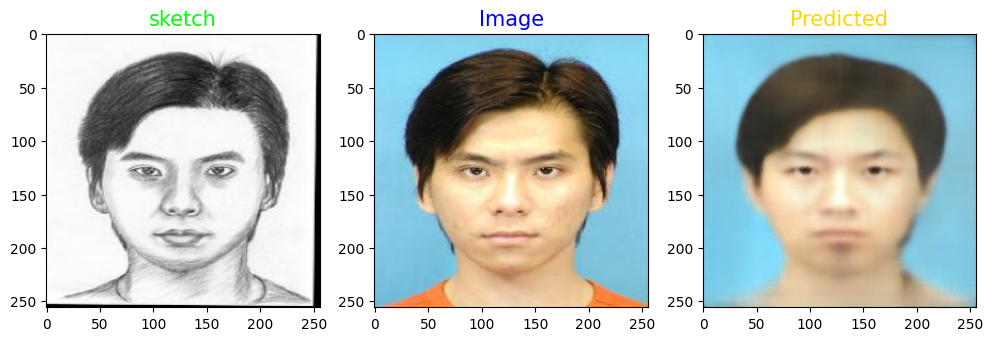

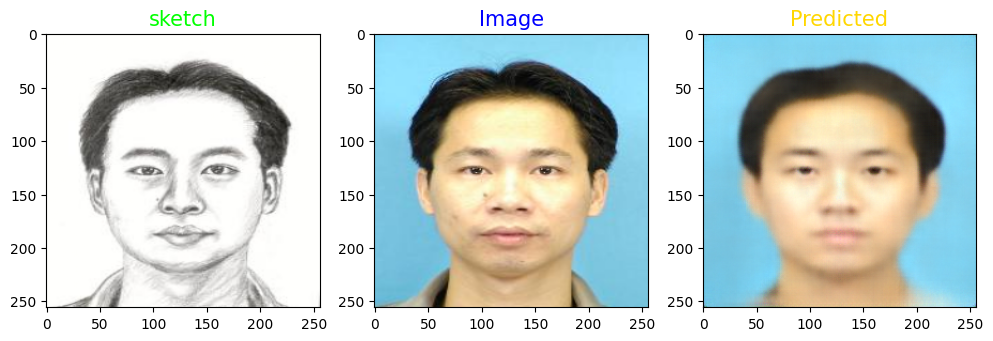

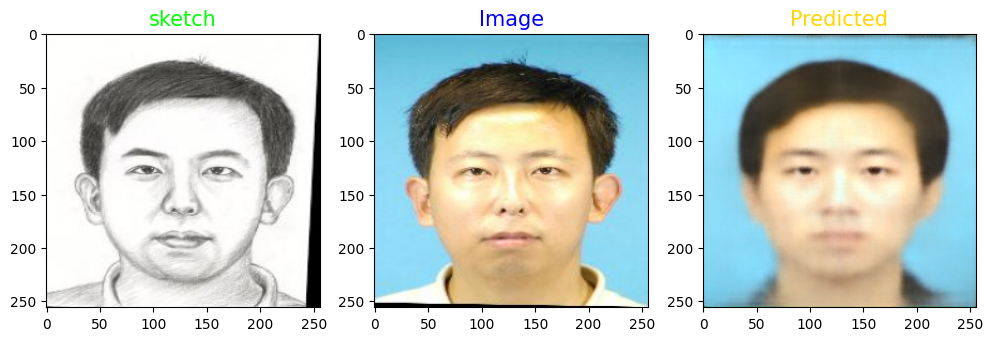

In [25]:
ls = [i for i in range(0,95,8)]
for i in ls:
    predicted =np.clip(model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)

In [32]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

# Load the image
img_path = "/content/predictnew.png"
img = image.load_img(img_path, target_size=(256, 256))  # Resize image to 256x256

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the model's expected input shape (None, 256, 256, 3)
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image array (optional, depending on your model's requirements)
img_array /= 255.0

# Print the shape of the image array to verify
print("Image shape:", img_array.shape)

# Make a prediction
predictions = model.predict(img_array)

# Print the predictions
print("Predictions:", predictions)


Image shape: (1, 256, 256, 3)
1/1 [==============================] - 0s 67ms/step
Predictions: [[[[0.3050831  0.18542257 0.25421524]
   [0.40789974 0.29920304 0.36728013]
   [0.41507065 0.31794745 0.5001267 ]
   ...
   [0.43944234 0.42986473 0.57381725]
   [0.38599992 0.35825574 0.418979  ]
   [0.28220856 0.32516265 0.36866885]]

  [[0.3539784  0.3384576  0.48761263]
   [0.44251382 0.52628756 0.55326533]
   [0.3984565  0.54568243 0.6386046 ]
   ...
   [0.50275815 0.6438435  0.68844855]
   [0.4558851  0.63264847 0.5476141 ]
   [0.3053127  0.4251328  0.49443156]]

  [[0.3435314  0.42279172 0.46043313]
   [0.42412823 0.54216325 0.56136584]
   [0.39991176 0.56223494 0.59881884]
   ...
   [0.47060382 0.65126616 0.6832551 ]
   [0.43203855 0.6463385  0.6540443 ]
   [0.3161202  0.52337533 0.52878904]]

  ...

  [[0.38427562 0.4190416  0.42964986]
   [0.49930066 0.6116543  0.64290226]
   [0.46166354 0.5947316  0.6430446 ]
   ...
   [0.4494921  0.5663131  0.6081439 ]
   [0.46413416 0.5441923  0.

Image shape: (1, 256, 256, 3)
1/1 [==============================] - 0s 34ms/step


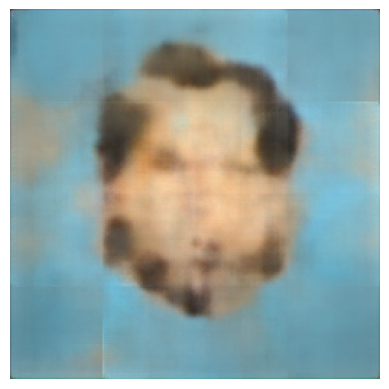

In [35]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the image
img_path = "/content/predictnew.png"
img = image.load_img(img_path, target_size=(256, 256))  # Resize image to 256x256

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the model's expected input shape (None, 256, 256, 3)
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image array (if needed by your model)
img_array /= 255.0

# Print the shape of the image array to verify
print("Image shape:", img_array.shape)

# Make a prediction
predicted_img_array = model.predict(img_array)

# The predicted output is also a numpy array. Remove the batch dimension.
predicted_img_array = np.squeeze(predicted_img_array, axis=0)

# (Optional) If the model outputs normalized pixel values, rescale them back to [0, 255]
predicted_img_array = np.clip(predicted_img_array * 255.0, 0, 255).astype(np.uint8)

# Display the predicted image
plt.imshow(predicted_img_array)
plt.axis('off')
plt.show()

# Save the predicted image
predicted_img = image.array_to_img(predicted_img_array)
predicted_img.save("predicted_image.png")


Image shape: (1, 256, 256, 3)
1/1 [==============================] - 0s 19ms/step


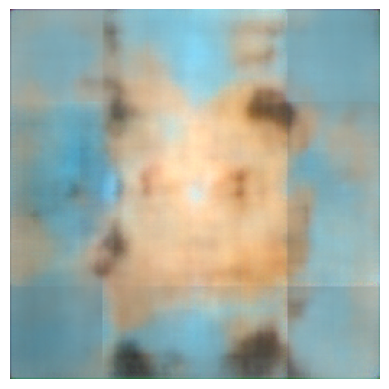

In [36]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the image
img_path = "/content/images.jpeg"
img = image.load_img(img_path, target_size=(256, 256))  # Resize image to 256x256

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the model's expected input shape (None, 256, 256, 3)
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image array (if needed by your model)
img_array /= 255.0

# Print the shape of the image array to verify
print("Image shape:", img_array.shape)

# Make a prediction
predicted_img_array = model.predict(img_array)

# The predicted output is also a numpy array. Remove the batch dimension.
predicted_img_array = np.squeeze(predicted_img_array, axis=0)

# (Optional) If the model outputs normalized pixel values, rescale them back to [0, 255]
predicted_img_array = np.clip(predicted_img_array * 255.0, 0, 255).astype(np.uint8)

# Display the predicted image
plt.imshow(predicted_img_array)
plt.axis('off')
plt.show()

# Save the predicted image
predicted_img = image.array_to_img(predicted_img_array)
predicted_img.save("predicted_image.png")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')